In [1]:
import numpy as np
import os
from skimage import io
from skimage import color, exposure, transform
from PIL import Image 
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sys
from shutil import copyfile
from skimage import data, img_as_float
from skimage import exposure
import shutil

import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D 
from keras.layers import Input, MaxPooling2D, Dense, Dropout, Activation, Flatten, ZeroPadding2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.layers.advanced_activations import LeakyReLU, ELU, PReLU
from keras.utils import np_utils 
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

Using TensorFlow backend.


In [2]:
def analyse_images(imgs_paths):
    
    data = []
    i = 0
    for img_path in imgs_paths:
        img_class = int(img_path.split('/')[-2])
        
        img = io.imread(img_path)
    
        # Histogram
        img_h = exposure.equalize_hist(img)
        
        data.append([img_h,img_class])
        
        i = i+1
        
        #Print every 10000 images
        if ((i % 10000)== 0):
            print ("Images processed: ")+str(i)
        
    return data




In [3]:
directory = 'SGTSD/Images_blurred/'
paths = []
number_signs = 0

if (not os.path.exists("used_images")):
    os.makedirs('used_images')

for sub_dir in os.listdir(directory):
    sd = directory+sub_dir+'/'
    if (sub_dir != ".DS_Store"):
        number_signs = number_signs+1
        images_paths = os.listdir(sd)
        np.random.shuffle(images_paths)
        for files in images_paths[:3400]:
            if (files.endswith(".jpg")==True):
                paths.append(directory+sub_dir+'/'+files)
                if (not os.path.exists("used_images/"+sub_dir)): os.mkdir("used_images/"+sub_dir)
                copyfile(directory+sub_dir+'/'+files, 'used_images/'+sub_dir+'/'+files)


                
orig_stdout = sys.stdout
f = open('Images_used.txt', 'w')
sys.stdout = f
for img_used in paths:
    print(img_used)
    print""
sys.stdout = orig_stdout
f.close()

np.random.shuffle(paths)
data = analyse_images(paths)
elements = []
classes = []
for d in data:
    elements.append(d[0])
    classes.append(d[1])

    
direct = 'val_set_blurred/'
val_paths = []
for sub_dir in os.listdir(direct):
    sd = direct+sub_dir+'/'
    if (sub_dir != ".DS_Store"):
        for files in os.listdir(sd):
            if (files.endswith(".csv")==False) and (files.endswith(".DS_Store")==False):
                val_paths.append(direct+sub_dir+'/'+files)
                
np.random.shuffle(val_paths)
val_data = analyse_images(val_paths)
val_elements = []
val_classes = []
for vd in val_data:
    val_elements.append(vd[0])
    val_classes.append(vd[1])

/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


Images processed: 10000
Images processed: 20000
Images processed: 30000
Images processed: 40000
Images processed: 50000
Images processed: 60000
Images processed: 70000
Images processed: 80000
Images processed: 90000
Images processed: 100000
Images processed: 110000
Images processed: 120000
Images processed: 130000
Images processed: 140000
Images processed: 150000
Images processed: 160000
Images processed: 170000


In [4]:
#PReLU(alpha_initializer="zero", weights=None)(norm_1)#ELU(alpha=0.001)(norm_1)#
def cnn_model(height,width,depth,number_signs):
    
    inp = Input(shape=(height, width, depth))
    
    conv_1 = Conv2D(32, (3, 3), padding='same')(inp)
    norm_1 = BatchNormalization()(conv_1)
    act1 = ELU(alpha=0.001)(norm_1)
    conv_2 = Conv2D(32, (3, 3), padding='same')(act1)
    norm_2 = BatchNormalization()(conv_2)
    act2 = ELU(alpha=0.001)(norm_2)
    pool_1 = MaxPooling2D((2, 2), data_format="channels_last")(act2)
    drop_1 = Dropout(0.2)(pool_1)

    conv_3 = Conv2D(64, (3, 3), padding='same')(drop_1)
    norm_3 = BatchNormalization()(conv_3)
    act3 = ELU(alpha=0.001)(norm_3)
    conv_4 = Conv2D(64, (3, 3), padding='same')(act3)
    norm_4 = BatchNormalization()(conv_4)
    act4 = ELU(alpha=0.001)(norm_4)
    pool_2 = MaxPooling2D((2, 2), data_format="channels_last")(act4)
    drop_2 = Dropout(0.2)(pool_2)
    
    conv_5 = Conv2D(128, (3, 3), padding='same')(drop_2)
    norm_5 = BatchNormalization()(conv_5)
    act5 = ELU(alpha=0.001)(norm_5)
    conv_6 = Conv2D(128, (3, 3), padding='same')(act5)
    norm_6 = BatchNormalization()(conv_6)
    act6 = ELU(alpha=0.001)(norm_6)
    pool_3 = MaxPooling2D((2, 2), data_format="channels_last")(act6)
    drop_3 = Dropout(0.2)(pool_3)
    
    
    flat = Flatten()(drop_3)
    hidden = Dense(512)(flat)
    norm_7 = BatchNormalization()(hidden)
    act7 = ELU(alpha=0.001)(norm_7)
    drop_4 = Dropout(0.5)(act7)
    out = Dense(number_signs, activation='softmax')(drop_4)

    model = Model(inputs=inp, outputs=out)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    
    
    return model
    

In [5]:
model = cnn_model(48,48,3,number_signs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
elu_1 (ELU)                  (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
elu_2 (ELU)                  (None, 48, 48, 32)        0         
__________

In [7]:
from sklearn.cross_validation import train_test_split

batch_size = 32
nb_epochs = 100

X_train = np.array(elements, dtype='float32')
Y_train = np.eye(number_signs, dtype='uint8')[classes]
X_val = np.array(val_elements, dtype='float32')
Y_val = np.eye(number_signs, dtype='uint8')[val_classes]


datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(X_train)

#early_stopping_monitor = EarlyStopping(patience=10)
filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

#history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),steps_per_epoch=1000,epochs=nb_epochs,callbacks=callbacks_list, validation_data=(X_val, Y_val))
history = model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epochs,callbacks=callbacks_list, validation_data=(X_val,Y_val))
score = model.evaluate(X_val, Y_val, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train on 170000 samples, validate on 2500 samples
Epoch 1/100
   352/170000 [..............................] - ETA: 4299s - loss: 1.1921e-07 - acc: 1.0000

KeyboardInterrupt: 

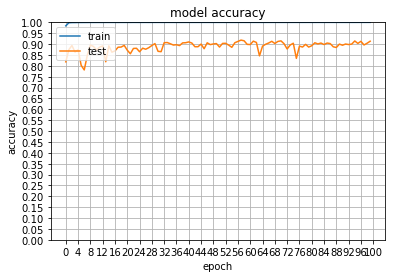

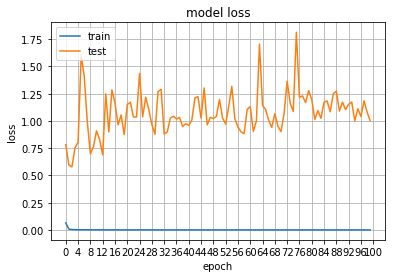

In [7]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0.0,1.0])
yintreval = np.arange(0.0, 1.05, 0.05)
xintreval = np.arange(0, 101, 4)
plt.yticks(yintreval)
plt.xticks(xintreval)
plt.grid()
fig = plt.figure()
fig.savefig('CNN -accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.xticks(xintreval)
plt.grid()
fig = plt.figure()
fig.savefig('CNN -loss.png')
plt.show()

In [8]:
orig_stdout = sys.stdout
f = open('Model_Summary.txt', 'w')
sys.stdout = f
print(model.summary())
sys.stdout = orig_stdout
f.close()

In [9]:
orig_stdout = sys.stdout
f = open('History.txt', 'w')
sys.stdout = f
print(history.history)
print('Test score:', score[0])
print('Test accuracy:', score[1])
sys.stdout = orig_stdout
f.close()

In [8]:
model.load_weights("weights.best.hdf5")
score = model.evaluate(X_val, Y_val, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

2496/2500 [============================>.] - ETA: 0s('Test score:', 0.89950380107314232)
('Test accuracy:', 0.91839999999999999)


In [9]:
from IPython.display import Image, display, SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz

# Save the model as png file
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)  

In [10]:
Y_predict = model.predict(X_val)

In [11]:
import operator

truth_table = np.zeros((50,50))
truth_table.astype(int)
orig_stdout = sys.stdout
f = open('Validation_set_predictions_summary.txt', 'w')
sys.stdout = f
for i in range(len(Y_predict)):
    obj_class = 0
    for c in range(len(Y_val[i])):
        if (Y_val[i][c]==1):
            obj_class = c
            break
    
    predictions = Y_predict[i]
    possible_classes = list(range(50))
    dictionary = {}
    
    for el in range(len(possible_classes)):
        dictionary[possible_classes[el]] = (Y_predict[i][el]*100)
    
    print ""
    print "Road Sign Actual Class: "+str(obj_class)
    print "Class predicted: "+str(max(dictionary.iteritems(), key=operator.itemgetter(1))[0])
    print "% per class: " + str(dictionary)
    print ""
    
    truth_table[int(obj_class),int(max(dictionary.iteritems(), key=operator.itemgetter(1))[0])] = truth_table[int(obj_class),int(max(dictionary.iteritems(), key=operator.itemgetter(1))[0])] + 1 

sys.stdout = orig_stdout
f.close()

In [12]:
truth_table = truth_table.astype(int)
np.savetxt('truth_table.csv', truth_table, fmt='%10.0f', delimiter=',')

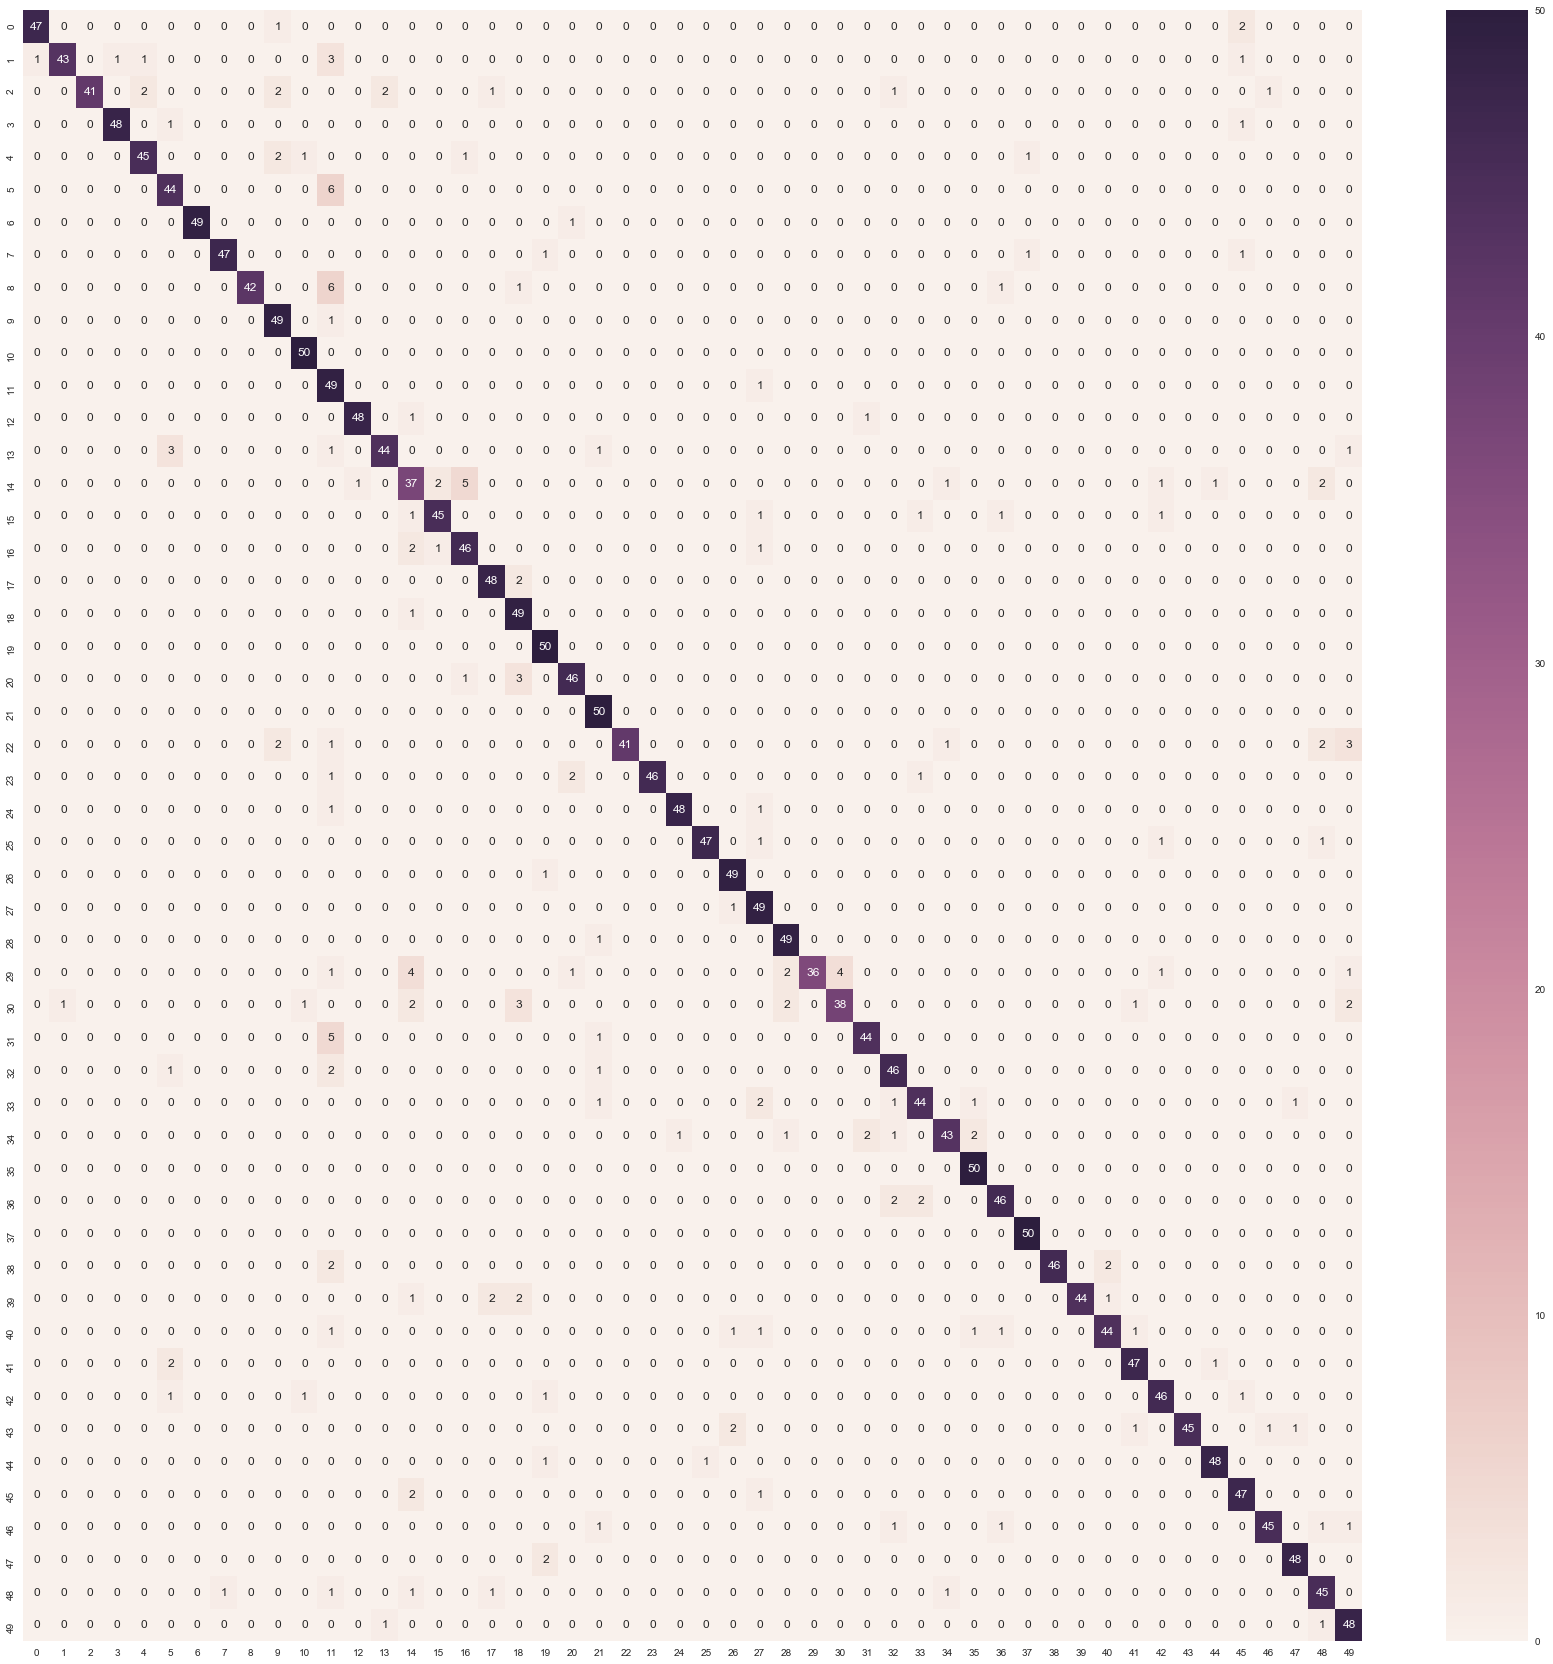

In [13]:
import seaborn as sn

plt.figure(figsize = (30,30))
sn.heatmap(truth_table, annot=True)
plt.show()

In [ ]:
from quiver_engine import server
server.launch(model,temp_folder='./imgs',input_folder='./val_set_blurred/3', port=5000)

Starting webserver from: /Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/quiver_engine


::1 - - [2017-09-14 13:22:02] "GET / HTTP/1.1" 200 823 0.011025
::1 - - [2017-09-14 13:22:02] "GET /app.c1d3d21cfba8c1aabed6806773c8f0ba.css HTTP/1.1" 200 5153 0.001868
::1 - - [2017-09-14 13:22:02] "GET /vendor.280c5ce1d78077ee8d66.js HTTP/1.1" 304 237 0.001660
::1 - - [2017-09-14 13:22:02] "GET /app.14b8092d6ea379715007.js HTTP/1.1" 304 239 0.001410
::1 - - [2017-09-14 13:22:02] "GET /model HTTP/1.1" 200 24415 0.006809
::1 - - [2017-09-14 13:22:02] "GET /inputs HTTP/1.1" 200 884 0.001717
::1 - - [2017-09-14 13:22:02] "GET /favicon.ico HTTP/1.1" 200 16191 0.001754
::1 - - [2017-09-14 13:22:03] "GET /input-file/4_11.jpg HTTP/1.1" 200 1457 0.001743
::1 - - [2017-09-14 13:22:03] "GET /input-file/4_10.jpg HTTP/1.1" 200 1330 0.001847
::1 - - [2017-09-14 13:22:03] "GET /input-file/4_1.jpg HTTP/1.1" 200 1492 0.001927
::1 - - [2017-09-14 13:22:03] "GET /input-file/4_12.jpg HTTP/1.1" 200 1420 0.001522
::1 - - [2017-09-14 13:22:03] "GET /input-file/4_13.jpg HTTP/1.1" 200 1437 0.001406
::1 - - [

::1 - - [2017-09-14 13:23:09] "GET /layer/conv2d_1/4_10.jpg HTTP/1.1" 500 444 0.146452
/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/quiver_engine/layer_result_generators.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ba..., inputs=Tensor("in...)`
  output=model.get_layer(layer_name).output
[2017-09-14 13:23:26,597] ERROR in app: Exception on /layer/batch_normalization_1/4_10.jpg [GET]
Traceback (most recent call last):
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/

::1 - - [2017-09-14 13:23:34] "GET /layer/batch_normalization_1/4_48.jpg HTTP/1.1" 500 444 0.110491
[2017-09-14 13:23:35,346] ERROR in app: Exception on /predict/4_49.jpg [GET]
Traceback (most recent call last):
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1612, in full_dispatch_reque

::1 - - [2017-09-14 13:23:37] "GET /layer/conv2d_1/4_44.jpg HTTP/1.1" 500 444 0.106014
[2017-09-14 13:23:39,168] ERROR in app: Exception on /layer/batch_normalization_1/4_44.jpg [GET]
Traceback (most recent call last):
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1612, in full_dispatc

::1 - - [2017-09-14 13:23:43] "GET /layer/batch_normalization_1/4_44.jpg HTTP/1.1" 500 444 0.102002
[2017-09-14 13:23:52,880] ERROR in app: Exception on /layer/conv2d_1/4_44.jpg [GET]
Traceback (most recent call last):
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask_cors/extension.py", line 161, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/Users/alexandrosstergiou/anaconda/lib/python2.7/site-packages/flask/app.py", line 1612, in full_dispatc

::1 - - [2017-09-14 13:26:38] "GET /layer/conv2d_1/4_42.jpg HTTP/1.1" 500 444 0.100468
